In [ ]:
from simple_multi_unet_model import multi_unet_model  # Uses softmax

from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt


n_classes = 29  # Number of classes for segmentation(room_0)

Using TensorFlow backend.


In [ ]:
train_images = []
directory_path = "data/train_images/"

# Get all image paths and sort them
img_paths = sorted(glob.glob(os.path.join(directory_path, "*.png")))

# Iterate through sorted image paths
for img_path in img_paths:
    #print(img_path)
    img = cv2.imread(img_path, 0)  # Read the image in grayscale mode
    img = np.pad(img, [(4, 4), (0, 0)], 'constant', constant_values=0)
    # img = cv2.resize(img, (SIZE_Y, SIZE_X))  # Uncomment if resizing is needed
    train_images.append(img)

# Convert list to array for machine learning processing
train_images = np.array(train_images)


In [ ]:
train_masks = []
directory_path = "data/train_masks/"

# Get all mask paths and sort them
mask_paths = sorted(glob.glob(os.path.join(directory_path, "*.png")))

# Iterate through sorted mask paths
for mask_path in mask_paths:
    #print(mask_path)
    mask = cv2.imread(mask_path, 0)  # Read the mask in grayscale mode
    mask = np.pad(mask, [(4, 4), (0, 0)], 'constant', constant_values=0)
    # mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)  # Uncomment if resizing is needed
    train_masks.append(mask)

# Convert list to array for machine learning processing
train_masks = np.array(train_masks)

In [ ]:
# Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1, 1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)



print(np.unique(train_masks_reshaped))
print(np.unique(train_masks_encoded_original_shape))

del train_masks_reshaped ,train_masks

/home/gonellas/azizi022/.conda/envs/U-net/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ 0  3 11 12 13 18 19 20 29 31 37 40 44 47 59 60 63 64 65 76 78 79 80 91
 92 93 95 97 98]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]


In [ ]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

# Create a subset of data for quick testing
# Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split

X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size=0.10, random_state=0)

# Further split training data to a smaller subset for faster training
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size=0.30, random_state=0)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

del X1, y1, X_do_not_use, y_do_not_use, train_images, train_masks_input

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled

(315, 688, 1200, 1) (315, 688, 1200, 1) (50, 688, 1200, 1) (50, 688, 1200, 1)
Class values in the dataset are ...  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]


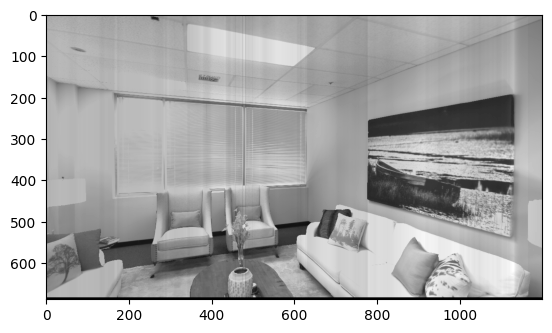

In [ ]:
plt.imshow(X_train[76, :, :, 0], cmap='gray')

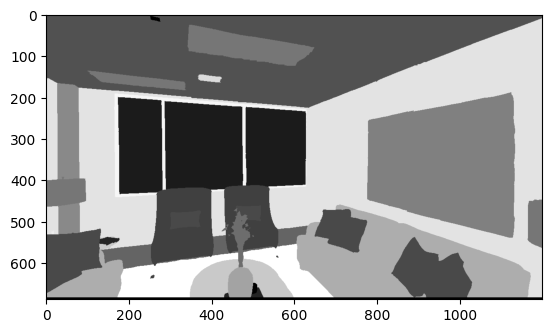

In [ ]:
plt.imshow(y_train[76, :, :, 0], cmap='gray')

In [ ]:
from keras.utils import to_categorical

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

print(y_train_cat.shape,y_test_cat.shape)

(315, 688, 1200, 29) (50, 688, 1200, 29)


In [ ]:
#Due to have imbalance dataset, I have used class_weights. (Larger weights indicate the minority of the class)
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(train_masks_reshaped_encoded),
                                                  y = train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)

del train_masks_reshaped_encoded

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

print(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

29 688 1200 1


In [ ]:
#compile the model(inputsize:688,1200,1)(16-32-64-128-258-128-64-32-16)(outputsize:688,1200,29)

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)


model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 688, 1200, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 688, 1200, 16 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 688, 1200, 16 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 688, 1200, 16 2320        dropout_1[0][0]     

In [ ]:
history = model.fit(X_train, y_train_cat,
                    batch_size=5,
                    verbose=1,
                    epochs=50,
                    validation_data=(X_test, y_test_cat),
                    #class_weight=class_weights,
                    shuffle=False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 315 samples, validate on 50 samples
Epoch 1/50






2023-12-12 23:53:11.283337: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-12-12 23:53:11.292554: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2445355000 Hz
2023-12-12 23:53:11.293574: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562fd4e263c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-12-12 23:53:11.293628: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-12-12 23:53:11.298839: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-12-12 23:53:11.447786: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562fd4e28880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-12 23:53:11.447884: I tensorflow/compiler/xla/s


315/315 [==============================] - 473s 2s/step - loss: 2.9603 - acc: 0.1712 - val_loss: 2.5719 - val_acc: 0.2894
Epoch 2/50
315/315 [==============================] - 493s 2s/step - loss: 2.4161 - acc: 0.2978 - val_loss: 2.3173 - val_acc: 0.3447
Epoch 3/50
315/315 [==============================] - 486s 2s/step - loss: 2.1328 - acc: 0.3433 - val_loss: 1.9665 - val_acc: 0.3975
Epoch 4/50
315/315 [==============================] - 474s 2s/step - loss: 1.9048 - acc: 0.3829 - val_loss: 1.7522 - val_acc: 0.4181
Epoch 5/50
315/315 [==============================] - 457s 1s/step - loss: 1.6953 - acc: 0.4168 - val_loss: 1.5570 - val_acc: 0.4522
Epoch 6/50
315/315 [==============================] - 429s 1s/step - loss: 1.4931 - acc: 0.4985 - val_loss: 1.4109 - val_acc: 0.5564
Epoch 7/50
315/315 [==============================] - 453s 1s/step - loss: 1.4687 - acc: 0.5204 - val_loss: 1.3187 - val_acc: 0.5605
Epoch 8/50
315/315 [==============================] - 444s 1s/step - loss: 1.21

In [ ]:
model.save('room_0.hdf5')

In [ ]:
model.load_weights('room_0.hdf5')

50/50 [==============================] - 13s 262ms/step
Accuracy is =  97.6474084854126 %


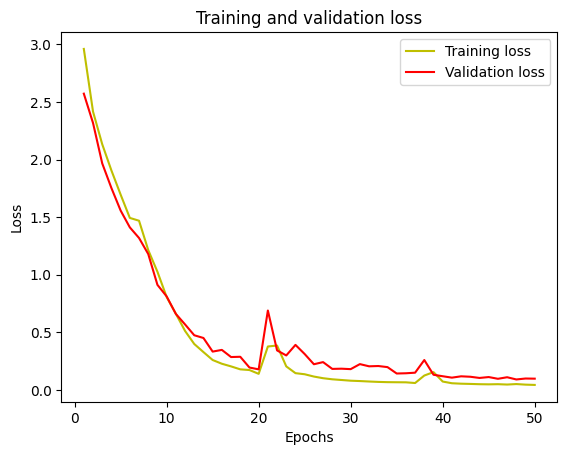

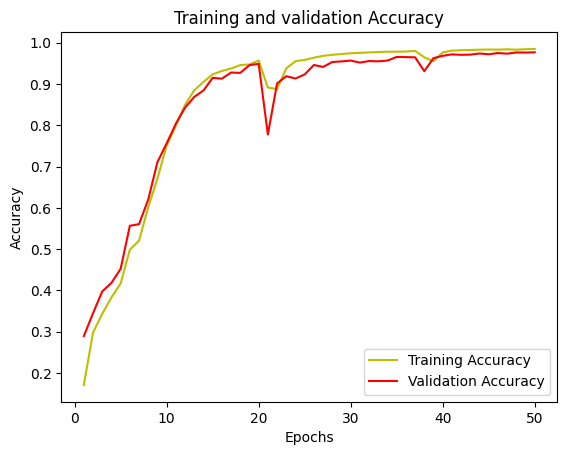

In [ ]:
# Evaluate the model

_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

###
# plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# For IOU accuray
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)

print(y_pred.shape)
print(y_pred_argmax.shape)
print(y_test.shape)

from sklearn.metrics import confusion_matrix

def mean_iou(y_true, y_pred, num_classes):
    """
    Calculate the Mean Intersection over Union (Mean IoU)

    Parameters:
    y_true (numpy.array): True labels
    y_pred (numpy.array): Predicted labels
    num_classes (int): Number of classes

    Returns:
    float: Mean IoU score
    """
    # Initialize the confusion matrix
    conf_mat = confusion_matrix(y_true.flatten(), y_pred.flatten(), labels=np.arange(num_classes))

    # Intersection for each class (diagonal of the confusion matrix)
    intersection = np.diag(conf_mat)

    # Union for each class
    ground_truth_set = conf_mat.sum(axis=1)
    predicted_set = conf_mat.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    # IoU for each class
    iou = intersection / union.astype(np.float32)

    # Remove NaNs (if union is zero)
    iou = np.nan_to_num(iou)

    # Mean IoU
    mean_iou = np.mean(iou)
    return mean_iou

n_classes = 29
mean_iou_value = mean_iou(y_test[:, :, :, 0], y_pred_argmax, n_classes)
print("Mean IoU =", mean_iou_value)

In [ ]:
# To calculate I0U for each class...

values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0, 0] / (
            values[0, 0] + values[0, 1] + values[0, 2] + values[0, 3] + values[1, 0] + values[2, 0] + values[3, 0])
class2_IoU = values[1, 1] / (
            values[1, 1] + values[1, 0] + values[1, 2] + values[1, 3] + values[0, 1] + values[2, 1] + values[3, 1])
class3_IoU = values[2, 2] / (
            values[2, 2] + values[2, 0] + values[2, 1] + values[2, 3] + values[0, 2] + values[1, 2] + values[3, 2])
class4_IoU = values[3, 3] / (
            values[3, 3] + values[3, 0] + values[3, 1] + values[3, 2] + values[0, 3] + values[1, 3] + values[2, 3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

(1, 688, 1200, 1)


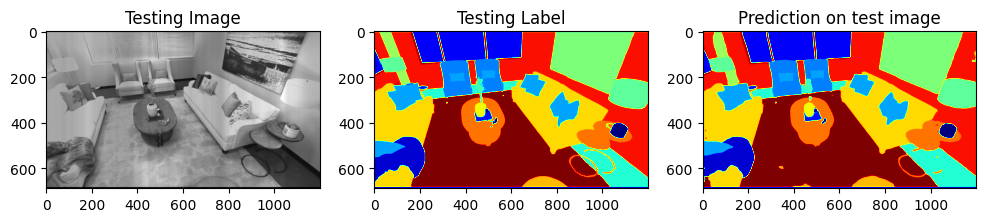

In [ ]:

import random

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]
test_img_norm = test_img[:, :, 0][:, :, None]
test_img_input = np.expand_dims(test_img_norm, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0, :, :]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:, :, 0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:, :, 0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()




In [ ]:
All_images = []
directory_path = "data/train_images/"

# Get all image paths and sort them
img_paths = sorted(glob.glob(os.path.join(directory_path, "*.png")))

# Iterate through sorted image paths
for img_path in img_paths:
    #print(img_path)
    img = cv2.imread(img_path, 0)  # Read the image in grayscale mode
    img = np.pad(img, [(4, 4), (0, 0)], 'constant', constant_values=0)
    # img = cv2.resize(img, (SIZE_Y, SIZE_X))  # Uncomment if resizing is needed
    All_images.append(img)

# Convert list to array for machine learning processing
All_images = np.array(All_images)


In [ ]:
All_masks = []
directory_path = "data/train_masks/"

# Get all mask paths and sort them
mask_paths = sorted(glob.glob(os.path.join(directory_path, "*.png")))

# Iterate through sorted mask paths
for mask_path in mask_paths:
    #print(mask_path)
    mask = cv2.imread(mask_path, 0)  # Read the mask in grayscale mode
    mask = np.pad(mask, [(4, 4), (0, 0)], 'constant', constant_values=0)
    # mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)  # Uncomment if resizing is needed
    All_masks.append(mask)

# Convert list to array for machine learning processing
All_masks = np.array(All_masks)

In [ ]:

All_images = np.expand_dims(All_images, axis=3)
All_images = normalize(All_images, axis=1)


In [ ]:
print(All_images.shape)
print(All_masks.shape)

(500, 688, 1200, 1)
(500, 688, 1200)


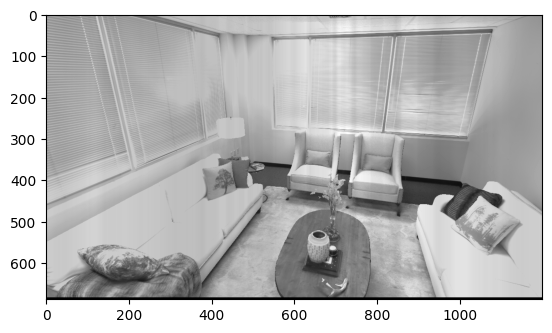

In [ ]:
plt.imshow(All_images[257, :, :, 0], cmap='gray')

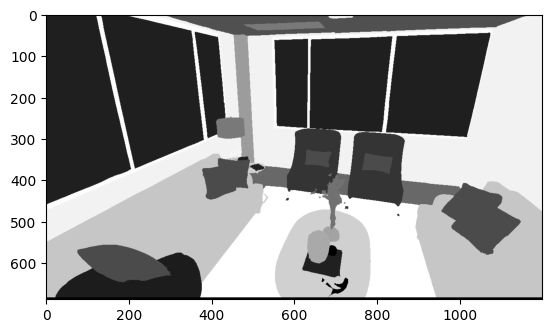

In [ ]:
plt.imshow(All_masks[257], cmap='gray')

In [ ]:
output_img = []


for i in range(0, All_images.shape[0]):

    input_img = All_images[i]
    input_img_norm = input_img[:, :, 0][:, :, None]
    input_img_input = np.expand_dims(input_img_norm, 0)
    prediction = (model.predict(input_img_input))
    output_img.append(np.argmax(prediction, axis=3)[0, :, :])


output_img = np.array(output_img)
print(output_img.shape)


(500, 688, 1200)


In [ ]:
value_map = {0: 0, 1: 3, 2: 11, 3: 12, 4: 13, 5: 18, 6: 19, 7: 20, 8: 29, 9: 31, 10: 37, 11: 40, 12: 44, 13: 47,
            14: 59, 15: 60, 16: 63, 17: 64, 18: 65, 19: 76, 20: 78, 21: 79, 22: 80, 23: 91, 24: 92, 25: 93, 26: 95,
            27: 97, 28: 98}

output_mask = []

for i in range(0,output_img.shape[0]):

    mask = output_img[i,4:-4, :]

    for original_value, new_value in value_map.items():

        indices = np.where(mask == original_value)
        mask[indices] = new_value

    mask_3_channels = np.stack((mask, mask, mask), axis=-1)

    output_mask.append(mask_3_channels)

output_mask = np.array(output_mask)

#print(output_mask.shape)

In [ ]:
save_directory = "/home/gonellas/azizi022/RR/U-net/outputmasks"
os.makedirs(save_directory, exist_ok=True)

# Iterate over each slice and save
for i in range(output_mask.shape[0]):

    slice_img = output_mask[i, :, :, :]

    # Construct the filename with leading zeros
    filename = f"{save_directory}/{str(i).zfill(4)}.png"

    # Save the image
    cv2.imwrite(filename, slice_img)